## Downloading the dataset directly from Kaggle

In [26]:
import os
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi

# Install kaggle if not already
!pip install kaggle --quiet

# Set environment variable for Kaggle API key
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()

# Make sure kaggle.json exists in the current folder
if not os.path.exists("kaggle.json"):
    raise FileNotFoundError("Place your kaggle.json file in the notebook directory.")

# Authenticate and download
api = KaggleApi()
api.authenticate()

# Download and unzip the dataset
api.dataset_download_files('uciml/sms-spam-collection-dataset', path='.', unzip=True)

# Move spam.csv to /data directory
os.makedirs('data', exist_ok=True)
if os.path.exists("spam.csv"):
    os.replace("spam.csv", os.path.join("data", "spam.csv"))



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset


## Importing required libraries

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
import string
import joblib

from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [28]:
df = pd.read_csv('data/spam.csv', encoding='latin-1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [29]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df.rename(columns={'v1': 'class', 'v2': 'text'}, inplace=True)
df.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


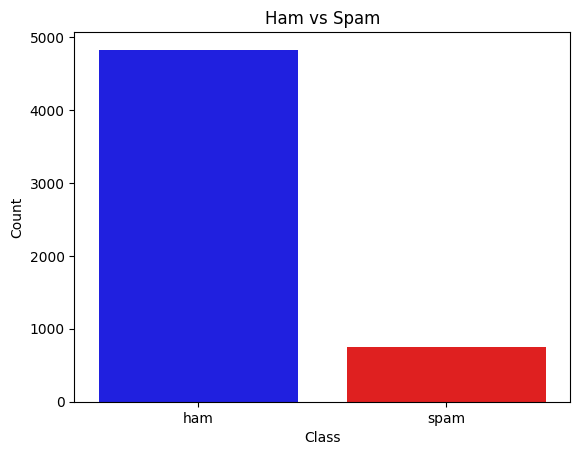

In [30]:
fig = sns.countplot(x=df['class'], palette=['blue', 'red'], hue=df['class'], legend=False)
fig.set_title('Ham vs Spam')
fig.set_xlabel('Class')
fig.set_ylabel('Count')
plt.show()

[('u', 1119), ('call', 576), ('2', 478), ('im', 462), ('get', 386), ('ur', 384), ('4', 287), ('dont', 279), ('go', 278), ('ok', 277), ('ltgt', 276), ('free', 275), ('know', 257), ('like', 242), ('got', 238)]


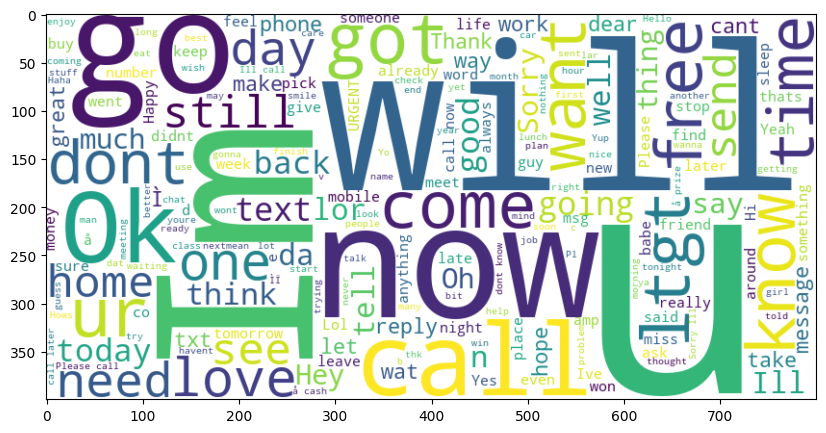

In [31]:
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def most_frequent_words(text):
    text = text.lower().split()
    words = []
    for i in text:
        if i not in stop_words:
            words.append(i)
    count = Counter(words)
    return count.most_common(15)

df['text'] =df ['text'].apply(remove_punctuation)
text = " ".join(df['text'])
stop_words=set(stopwords.words('english'))

most_common = most_frequent_words(text)
print(most_common)

cloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(cloud, interpolation='bilinear')
plt.show()

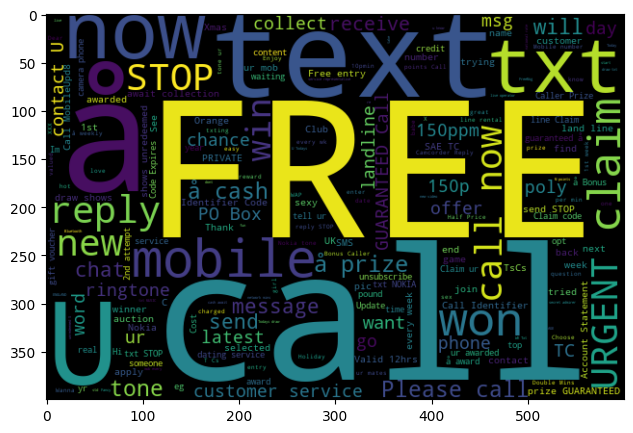

In [32]:
spam_words = ' '.join(df[df['class'] == 'spam']['text'])

cloud = WordCloud(width=600, height=400).generate(spam_words).to_image()
plt.figure(figsize=(10, 5))
plt.imshow(cloud, interpolation='bilinear')
plt.show()

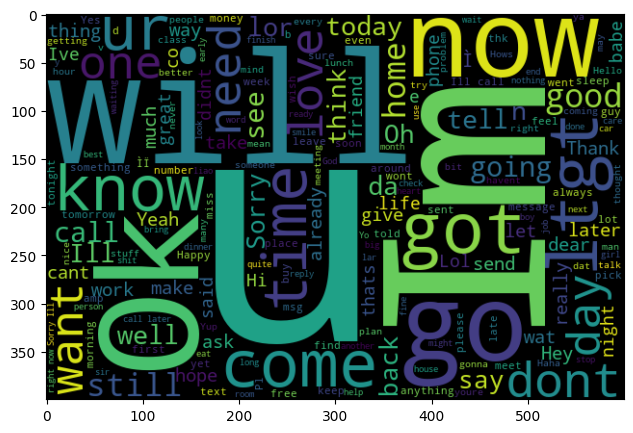

In [33]:
ham_words = ' '.join(df[df['class'] == 'ham']['text'])

cloud = WordCloud(width=600, height=400).generate(ham_words).to_image()
plt.figure(figsize=(10, 5))
plt.imshow(cloud, interpolation='bilinear')
plt.show()

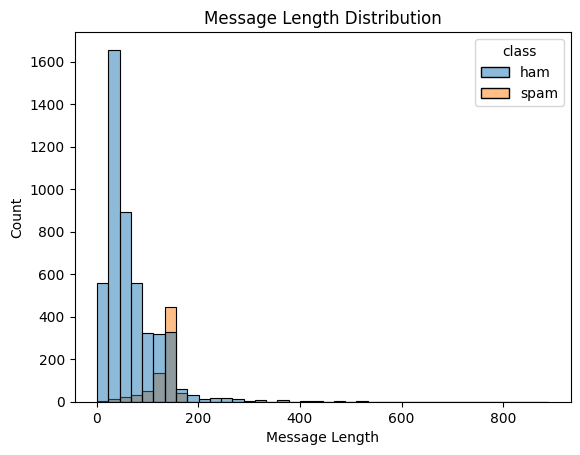

In [34]:
df['message_length'] = df['text'].apply(len)

sns.histplot(df, x='message_length', hue='class', bins=40)
plt.xlabel("Message Length")
plt.title("Message Length Distribution")
plt.show()

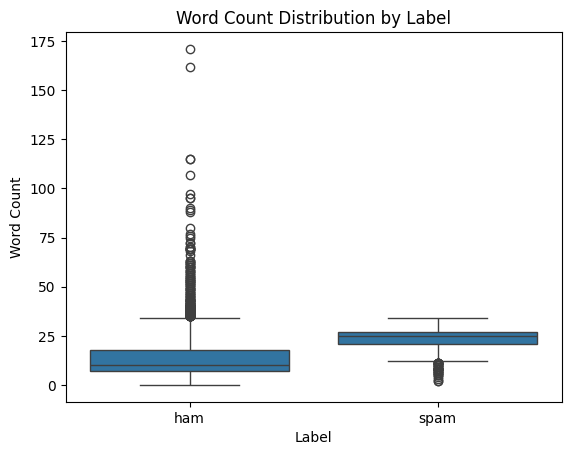

In [35]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
sns.boxplot(x='class', y='word_count', data=df)
plt.xlabel("Label")
plt.ylabel("Word Count")
plt.title("Word Count Distribution by Label")
plt.show()

In [36]:
df['class'].value_counts(normalize=True)

class
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64

In [37]:
stemmer = SnowballStemmer("english")

df['message']=df['text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

In [38]:
x = df['text']
y = df['class']

encode = LabelEncoder()
y = encode.fit_transform(y)

tfidf = TfidfVectorizer(stop_words='english', max_df=0.95, ngram_range=(1,2),min_df=5)
x = tfidf.fit_transform(x)

joblib.dump(tfidf, 'vectorizer.pkl')

x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=42)

# Building the model

## Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression

model1=LogisticRegression(class_weight='balanced', max_iter=1000)
model1.fit(x_train, y_train)

y_pred1 = model1.predict(x_test)
print("Accuracy: ",accuracy_score(y_test, y_pred1))
print(classification_report(y_test, y_pred1))

Accuracy:  0.9757847533632287
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       965
           1       0.93      0.89      0.91       150

    accuracy                           0.98      1115
   macro avg       0.96      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115



## Multinomial Naive Bayes

In [40]:
from sklearn.naive_bayes import MultinomialNB
model2=MultinomialNB()
model2.fit(x_train, y_train)

y_pred2 = model2.predict(x_test)
print("Accuracy: ",accuracy_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

Accuracy:  0.9730941704035875
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       965
           1       1.00      0.80      0.89       150

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115



## Linear SVM

In [41]:
from sklearn.svm import LinearSVC
model3=LinearSVC(class_weight='balanced')
model3.fit(x_train, y_train)

y_pred3 = model3.predict(x_test)
print("Accuracy: ",accuracy_score(y_test, y_pred3))
print(classification_report(y_test, y_pred3))

Accuracy:  0.97847533632287
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       965
           1       0.93      0.91      0.92       150

    accuracy                           0.98      1115
   macro avg       0.96      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115



## Random Forest Classifier

In [42]:
from sklearn.ensemble import RandomForestClassifier
model4=RandomForestClassifier(class_weight='balanced', n_estimators=200)
model4.fit(x_train, y_train)

y_pred4 = model4.predict(x_test)
print("Accuracy: ",accuracy_score(y_test, y_pred4))
print(classification_report(y_test, y_pred4))

Accuracy:  0.9730941704035875
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       965
           1       0.98      0.82      0.89       150

    accuracy                           0.97      1115
   macro avg       0.97      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115



# Hyperparameter Tuning

In [43]:
from sklearn.model_selection import GridSearchCV

#Logistic Regression
param_grid={'C': [0.01, 0.1, 1, 10],'solver': ['liblinear', 'lbfgs']}

grid = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000),param_grid, scoring='accuracy', cv=5)
grid.fit(x_train, y_train)

print("Best params:", grid.best_params_)
model1=grid.best_estimator_

Best params: {'C': 10, 'solver': 'lbfgs'}


In [44]:
# Linear SVM
param_grid_svm={'C': [0.01, 0.1, 1, 10],'loss': ['hinge', 'squared_hinge']}

grid_svm=GridSearchCV(LinearSVC(class_weight='balanced', max_iter=1000),param_grid_svm, cv=5, scoring='accuracy')
grid_svm.fit(x_train, y_train)

print("Best LinearSVC Params:", grid_svm.best_params_)

Best LinearSVC Params: {'C': 0.1, 'loss': 'squared_hinge'}


In [45]:
# Multinomial NB
param_grid_nb={'alpha': [0.01, 0.1, 1, 5, 10],'fit_prior': [True, False]}

grid_nb = GridSearchCV(MultinomialNB(),param_grid_nb, cv=5, scoring='accuracy')
grid_nb.fit(x_train, y_train)

print("Best MultinomialNB Params:", grid_nb.best_params_)

Best MultinomialNB Params: {'alpha': 0.1, 'fit_prior': True}


In [46]:
print("Best Logistic Regression score:", grid.best_score_)
print("Best LinearSVC Score:", grid_svm.best_score_)
print("Best MultinomialNB Score:", grid_nb.best_score_)

Best Logistic Regression score: 0.9809288701665384
Best LinearSVC Score: 0.9798065357108706
Best MultinomialNB Score: 0.9795813138862466


In [47]:
joblib.dump(model1, 'model.pkl')

['model.pkl']

In [48]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

model=joblib.load('model.pkl')
vectorizer=joblib.load('vectorizer.pkl')

def preprocess_text(text):
    text=text.lower()
    text=re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])
    stemmer = SnowballStemmer("english")
    return text

def predict_spam_or_ham(text):
    text=preprocess_text(text)
    text_tfidf = vectorizer.transform([text])

    prediction = model.predict(text_tfidf)

    return 'Spam' if prediction == 1 else 'Ham'

In [49]:
input_text="Congratulations! You've won a lottery. Click here to claim your prize."
prediction=predict_spam_or_ham(input_text)
print(f"Prediction: {prediction}")

Prediction: Spam
